<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/4/lab.ipynb">link</a>

# **Introduction**

In the beginning of this lab I wanted to complete it using YOLO alghorithm. However, when I read more resources I found proposed neural network architecture, that I should try to use. So I stick with this option.

<div style="align-items: center; justify-content: center">
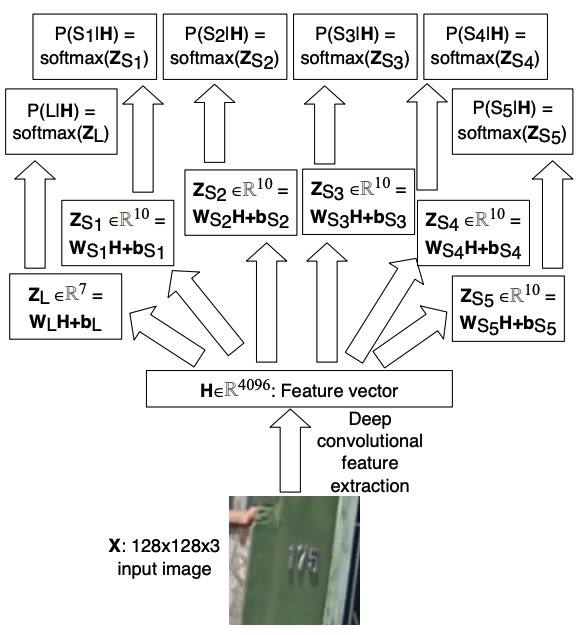</img>
<i style="align-items: center; justify-content: center">Picture 1 - proposed architecture of a neural network</i>
</div>

# **Part 1-1: Download and extract SVNH dataset**

Publication: https://arxiv.org/abs/1312.6082

In [0]:
!wget "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/extra_32x32.mat"

In [6]:
!wget "http://ufldl.stanford.edu/housenumbers/train.tar.gz"
!wget "http://ufldl.stanford.edu/housenumbers/test.tar.gz"
!wget "http://ufldl.stanford.edu/housenumbers/extra.tar.gz"

--2020-03-13 10:26:53--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  17.4MB/s    in 25s     

2020-03-13 10:27:23 (15.4 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

--2020-03-13 10:27:25--  http://ufldl.stanford.edu/housenumbers/test.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276555967 (264M) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 263.74M  17.8MB/s    in 18s     

2020-03-13 10:27:43 (14.6 MB/s) - ‘test.tar.gz’ saved [276555967/2

Extract .zip

In [0]:
!mkdir train
!mkdir test
!mkdir extra
!tar xvzf train.tar.gz -C train
!tar xvzf test.tar.gz -C test
!tar xvzf extra.tar.gz -C extra

In [8]:
%ls

extra/  extra.tar.gz  sample_data/  test/  test.tar.gz  train/  train.tar.gz


Read data:

In [0]:
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
extra = loadmat('test_32x32.mat')

X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

Check the data:

In [0]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (32, 32, 3, 73257)
y_train.shape:  (73257, 1)
X_test.shape:  (32, 32, 3, 26032)
y_test.shape:  (26032, 1)


Since we now know the structure of the data, we can visulize it:

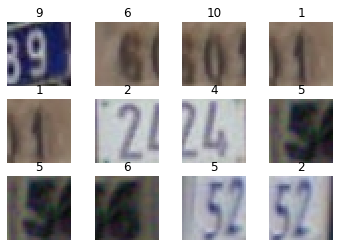

In [0]:
import matplotlib.pyplot as plt

X_train = X_train[:,:,:,:]
X_test = X_test[:,:,:,:]

start = 50

fig, ax = plt.subplots(3, 4)
for row in range(3):
    for col in range(4):
        ax[row, col].imshow(X_train[:,:,:,start+row*3+col])
        ax[row, col].axis('off')
        ax[row, col].set_title('{}'.format(y_train[start+row*3+col, 0]))
plt.show()

# **Common const definition:**

In [0]:
IMAGE_WIDTH=28
IMAGE_HEIGHT=28
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# **Part 1-2: Download and extract MNIST dataset**

In [0]:
from keras.datasets import mnist


# the data, split between train and test sets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Normalizing the input
x_train_mnist= x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0],28,28,1)

Helper function:

In [0]:
import numpy as np
import cv2

def x_to_nn_input(X):
    x = np.reshape(X, (X.shape[0], 28, 28))
    x = np.repeat(x[..., np.newaxis], 3, -1)
    return x

In [46]:
x_to_nn_input(x_train_mnist).shape

(60000, 28, 28, 3)

In [0]:
length=[1,0,0,0,0]
number=[0,1,0,0,0,0,0,0,0,0]
nan=[0,0,0,0,0,0,0,0,0,0]

def y_mnist_to_NN_architecture_output(y):
  arr = [np.array([]), [], [], [], [], []]
  for i in range(6):
      for j in range(y.shape[0]):
          if i == 0:
              arr[0].append(1)
          if i == 1:
              arr[1].append(y[j])
          if i >= 2:
              arr[i].append(NOT_A_NUMBER) 
  return np.asarray(arr, dtype=np.uint8)

In [91]:
y_mnist_to_NN_architecture_output(y_train_mnist)[0:32]

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 5,  0,  4, ...,  5,  6,  8],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]], dtype=uint8)

# **Part 1-3: Build a NN model**

NN model

In [34]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

input=Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), name="input")

H=Conv2D(16,(3,3),activation='relu',padding="same")(input)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same")(H)
H=Dropout(0.25)(H)

H=Conv2D(32,(3,3),activation='relu',padding="same")(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same",strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(48,(3,3),activation='relu',padding="same")(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same")(H)
H=Dropout(0.25)(H)

H=Conv2D(64,(3,3),activation='relu',padding="same")(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same",strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(128,(3,3),activation='relu',padding="same")(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same")(H)
H=Dropout(0.25)(H)

H=Conv2D(192,(3,3),activation='relu',padding="same")(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same",strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(192,(3,3),activation='relu',padding="same")(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same")(H)
H=Dropout(0.25)(H)

H=Conv2D(192,(3,3),activation='relu',padding="same")(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding="same",strides=1)(H)
H=Dropout(0.25)(H)

hidden9=Flatten()(H)      
hidden9=Dense(4096, activation='relu')(hidden9)

hidden10=Dense(4096, activation='relu')(hidden9)

length=Dense(6, activation='softmax', name='length')(hidden10)
digit1=Dense(11, activation='softmax', name='digit1')(hidden10)
digit2=Dense(11, activation='softmax', name='digit2')(hidden10)
digit3=Dense(11, activation='softmax', name='digit3')(hidden10)
digit4=Dense(11, activation='softmax', name='digit4')(hidden10)
digit5=Dense(11, activation='softmax', name='digit5')(hidden10)

model = Model(inputs=input, outputs=[length,digit1,digit2,digit3,digit4,digit5], name='svhn_model')

model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "svhn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 28, 28, 16)   448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 28, 28, 16)   64          conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 14, 14, 16)   0           batch_normalization_24[0][0]     
_________________________________________________________________________________________

# **Part 1: Train on mnist dataset**

Const definition:

In [0]:
MAX_LENGTH = 5
NOT_A_NUMBER = 10

Conversion for y value:

Data generator:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=8, 
    width_shift_range=0.08, 
    shear_range=0.3, 
    height_shift_range=0.08, 
    zoom_range=0.08,
    rescale=1./255
)
test_gen = ImageDataGenerator(rescale=1./255)

training_set= train_gen.flow(
    x_to_nn_input(x_train_mnist), 
    y_mnist_to_NN_architecture_output(y_train_mnist), 
    batch_size=32
)

test_set= train_gen.flow(
    x_to_nn_input(x_test_mnist),
    y_mnist_to_NN_architecture_output(y_test_mnist),
    batch_size=32
 )

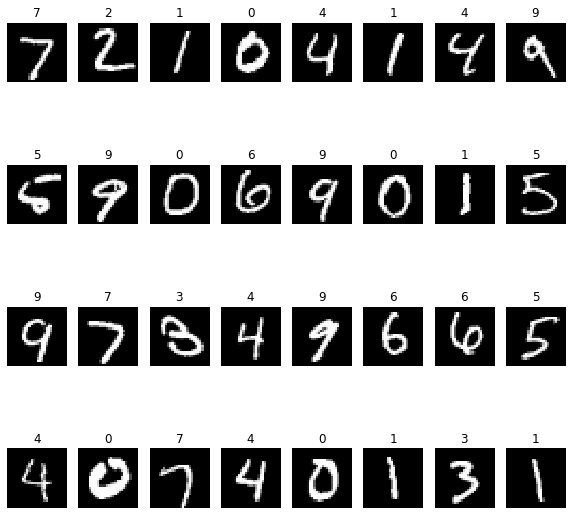

In [92]:
#image_batch, label_batch = next(train_gen)
show_batch(x_to_nn_input(x_test_mnist)[0:32], y_mnist_to_NN_architecture_output(y_test_mnist)[0:32])

NN train

In [93]:
history = model.fit(
    x_to_nn_input(x_test_mnist),
    y_mnist_to_NN_architecture_output(y_test_mnist),
    epochs=10
)

ValueError: ignored

# **Part 2: Train on svnh dataset**

Dataset preprocessing:

In [21]:
import h5py
import pandas as pd
import numpy as np

# The DigitStructFile is just a wrapper around the h5py data. It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struct data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self, n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    # bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self, attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # Return a restructured version of the dataset.
    #
    #   Return a list of such dicts:
    #      'filename': filename of the samples
    #      'labels': list of such digits presented by an 6-array
    #
    # Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure(self):
        labels = []
        filenames=[]

        for i in range(len(self.digitStructBbox)):
            bbox = self.digitStructBbox[i].item()
            label_attribute = self.inf[bbox]['label']
            label = self.bboxHelper(label_attribute)
            # since one of the numbers has 6 numbers! (it is > 5)
            label = [0 if digit == 10 else digit for digit in label]
            length = len(label)
            name = self.getName(i)

            if (length > MAX_LENGTH):
                continue

            for _ in range(MAX_LENGTH - length):
                label.append(NOT_A_NUMBER)
            label.append(length)

            labels.append(label)
            filenames.append(name)

        return np.array(filenames), np.array(labels).astype(int)

    def to_dataframe(self):
        filenames, labels = self.getAllDigitStructure()

        return pd.DataFrame({
          'filename': filenames,
          'length': labels[:,5],
          'digit1': labels[:,0],
          'digit2': labels[:,1],
          'digit3': labels[:,2],
          'digit4': labels[:,3],
          'digit5': labels[:,4]
      })


df = DigitStructFile('train/train/digitStruct.mat').to_dataframe()

df.head()

,filename,length,digit1,digit2,digit3,digit4,digit5
0,1.png,2,1,9,10,10,10
1,2.png,2,2,3,10,10,10
2,3.png,2,2,5,10,10,10
3,4.png,2,9,3,10,10,10
4,5.png,2,3,1,10,10,10


Display one of the image:

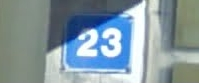

In [12]:
from IPython.display import Image

Image('train/train/2.png')

Dataset split

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.10)

Image generator:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# use data augmentation
train_datagen_aug = ImageDataGenerator(
      rotation_range=10,
      rescale=1./255,
      shear_range=0.1,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1
)

test_gen = ImageDataGenerator(rescale=1./255)

Data flows:

In [29]:
TRAIN_PATH = 'train/train'
TEST_PATH = 'test/test'

y_col = ['length', 'digit1', 'digit2', 'digit3', 'digit4', 'digit5']
total_train = train.shape[0]
total_validate = val.shape[0]
batch_size = 32  # since Andrew Ng told, that better use 2^n

train_generator = train_datagen_aug.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

val_generator = test_gen.flow_from_dataframe(
    val, 
    TRAIN_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

Found 30060 validated image filenames.
Found 3341 validated image filenames.


Show these examples:

[array([2, 3, 2, 2, 1, 2, 1, 2, 4, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2,
       2, 2, 3, 1, 3, 3, 1, 3, 2, 3]), array([3, 1, 7, 7, 5, 2, 9, 6, 1, 5, 8, 1, 1, 1, 2, 6, 3, 4, 2, 6, 6, 3,
       1, 1, 4, 2, 6, 4, 5, 6, 8, 1]), array([ 5,  8,  9,  7, 10,  2, 10,  0,  4,  7,  3,  8,  2,  5,  2,  4,  9,
        4,  3, 10, 10,  8,  0,  4,  8, 10,  4,  6, 10,  5,  1,  4]), array([10,  9, 10, 10, 10, 10, 10, 10,  3, 10, 10,  1, 10, 10, 10,  0, 10,
       10, 10, 10, 10, 10, 10, 10,  0, 10,  1,  3, 10,  9, 10,  2]), array([10, 10, 10, 10, 10, 10, 10, 10,  0, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])]


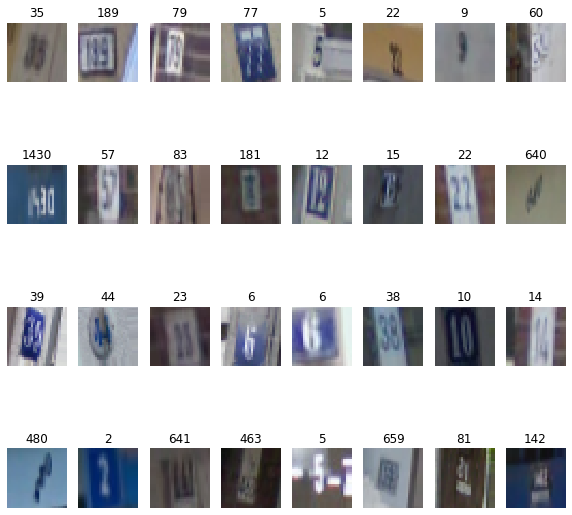

In [66]:
import matplotlib.pyplot as plt

def show_batch(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4,8,n+1)
        plt.imshow(image_batch[n])
        length=label_batch[0][n]
        title=''.join([str(label_batch[c+1][n]) for c in range(length)])
        plt.title(title)
        plt.axis('off')

image_batch, label_batch = next(train_generator)
print(label_batch)
show_batch(image_batch, label_batch)

Train NN:

In [35]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit_generator(
    train_generator, 
    epochs=100,
    validation_data=val_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks_list
)

#model = load_model("model.h5")

Epoch 1/100
104/939 [==>...........................] - ETA: 27s - loss: 7.2823 - length_loss: 1.1588 - digit1_loss: 2.0845 - digit2_loss: 2.3800 - digit3_loss: 1.3536 - digit4_loss: 0.2940 - digit5_loss: 0.0114 - length_acc: 0.4426 - digit1_acc: 0.2500 - digit2_acc: 0.1469 - digit3_acc: 0.7052 - digit4_acc: 0.9609 - digit5_acc: 0.9991
Epoch 00001: loss improved from inf to 7.09284, saving model to model.h5
939/939 [==============================] - 74s 79ms/step - loss: 7.0923 - length_loss: 1.0653 - digit1_loss: 2.0613 - digit2_loss: 2.3641 - digit3_loss: 1.3046 - digit4_loss: 0.2887 - digit5_loss: 0.0083 - length_acc: 0.5458 - digit1_acc: 0.2696 - digit2_acc: 0.1654 - digit3_acc: 0.6943 - digit4_acc: 0.9553 - digit5_acc: 0.9987 - val_loss: 7.2823 - val_length_loss: 1.1588 - val_digit1_loss: 2.0845 - val_digit2_loss: 2.3800 - val_digit3_loss: 1.3536 - val_digit4_loss: 0.2940 - val_digit5_loss: 0.0114 - val_length_acc: 0.4426 - val_digit1_acc: 0.2500 - val_digit2_acc: 0.1469 - val_digi

KeyboardInterrupt: ignored

# **Part 3: ?**

# **Part 4: Export model to tensorflow lite**

Convert model to tensorflow lite, in order to use it on weak devices:

In [0]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model_file('initial.h5') 
tfmodel = converter.convert() 
open("model.tflite", "wb").write(tfmodel)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 64 variables.
INFO:tensorflow:Converted 64 variables to const ops.


286785448

Download lite model:

In [0]:
from google.colab import files

files.download('model.tflite') 

# **Afterward. Test result**

Write here about my results. Attach various screenshots.

# **Resources**

- Publication from youtube link: https://arxiv.org/abs/1312.6082
- https://github.com/penny4860/Yolo-digit-detector
- https://github.com/dyckia/SVHN-CNN/blob/master/SVHN.ipynb